# 대출 상품 투자 위험도 줄이기
## 1.  데이터 확인 및 분석 프로세스 수집

사용 데이터: Kaggle의 Lending Club 데이터  
- 데이터: https://www.kaggle.com/datasets/wordsforthewise/lending-club
- 대출 용어 Dictionary: https://data.world/lpetrocelli/lendingclub-loan-data-2017-q-1

`loan_data_item_description.xlsx` 파일을 보면 피처 항목에 대한 설명이 있음  
- 빨간색 항목: 결측값을 최대값으로 채울지 최소값으로 채울지 고민해야 하는 피쳐


### 분석 목표: 고위험/고금리 대출 중 양호한 대출 분류 모델을 만들어 예측

## 2. 데이터 전처리
- 대출용어 사전 결측값 제거
- 대출 용어 사전과 대출 승인 데이터 문자열 규칙 맞추기
- 대출 승인 데이터 컬럼과 대출 용어 컬럼간 차이 확인
- 대출 시점(대출 용어 사전)에서의 용어 중 대출 승인 데이터 컬럼과 같은 의미인 용어를 동일하게 맞추기
- 대출 용어 사전과 대출 승인 데이터 컬럼 이름이 같은 컬럼만 가져오기

### 2.1 탐색적 데이터분석
- 데이터 타입별 Feature 변환
  1. 범주형 데이터 확인
  2. 범주형 문자열 데이터 중 날짜/기간/고유ID 데이터 처리
- 결측값 처리
  1. 컬럼별 결측값 비율 구한 후 비율=1인 컬럼 제거
  2. 결측값 채우기
- 변수 간 상관성에 따른 데이터 정제
  1. 숫자형 컬럼 데이터의 유일한 값 개수 확인
  2. 숫자형 데이터 상관도에 따른 컬럼 제거
  3. 범주형 데이터의 유일한 값 개수 확인
  4. 범주형 데이터 상관도에 따른 컬럼 제거
- 예측할 Feature 생성
  - 대출 상태를 보여주는 `loan_status`를 예측 변수 Feature로 함

### 2.2 데이터 준비를 위한 EDA 및 전처리

#### 1. 데이터 불러오기

In [1]:
### 필요한 파이썬 라이브러리 설치 ###
# ! pip install --upgrade pip
! pip install catboost
# ! pip install pandas==0.25.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

##### 1) 대출 승인 내역 불러오기  
- issue_d 컬럼은 parse_dates 사용
- infer_datetime_format = True
- reset_index(drop=True) 사용

In [3]:
data = pd.read_csv(
    '/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/03_decrease_risk_of_loan_item_investment/archive/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'],
    infer_datetime_format=True,
    low_memory=False
)

In [4]:
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


##### 2) 대출용어 사전 불러오기
- pandas의 read_excel 사용 / Excel Sheet 중 2번째 (sheet_name=1)을 불러옴

In [5]:
browse_notes = pd.read_excel('/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/03_decrease_risk_of_loan_item_investment/LCDataDictionary.xlsx',
                             sheet_name=1)
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


#### 2. 데이터 전처리  
- 기준정보 데이터와 대출승인 데이터의 정합성 맞추기  

##### 1) 대출용어 사전 결측값 제거

In [6]:
browse_notes['BrowseNotesFile'].dropna().values

array(['acceptD', 'accNowDelinq', 'accOpenPast24Mths', 'addrState',
       'all_util', 'annual_inc_joint', 'annualInc', 'application_type',
       'avg_cur_bal', 'bcOpenToBuy', 'bcUtil', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'creditPullD', 'delinq2Yrs',
       'delinqAmnt', 'desc', 'dti', 'dti_joint', 'earliestCrLine',
       'effective_int_rate', 'emp_title', 'empLength', 'expD',
       'expDefaultRate', 'ficoRangeHigh', 'ficoRangeLow', 'fundedAmnt',
       'grade', 'homeOwnership', 'id', 'il_util', 'ils_exp_d',
       'initialListStatus', 'inq_fi', 'inq_last_12m', 'inqLast6Mths',
       'installment', 'intRate', 'isIncV', 'listD', 'loanAmnt',
       'max_bal_bc', 'memberId', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mortAcc', 'msa',
       'mths_since_last_major_derog', 'mths_since_oldest_il_open',
       'mths_since_rcnt_il', 'mthsSinceLastDelinq', 'mthsSinceLastRecord',
       'mthsSinceMostRecentInq', 'mthsSinceRecentBc',

In [7]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values

##### 2) 대출용어 사진과 대출 승인 데이터 문자열 규칙 맞추기  
- 대문자, 숫자 앞에 '_'를 붙여주고 모두 소문자 변환
  > re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower()
- 공백 처리
  > .strip()

In [8]:
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [9]:
browse_feat

['accept_d',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc_joint',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_pull_d',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'effective_int_rate',
 'emp_title',
 'emp_length',
 'exp_d',
 'exp_default_rate',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'ils_exp_d',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'is_inc_v',
 'list_d',
 'loan_amnt',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'msa',
 'mths_since_last_major_derog',
 'mths_since_oldest_il_open',
 'mths_since_rcnt_il',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_most_recent_inq',
 'mths_since_recent_b

##### 3) 대출승인 데이터 컬럼과 대출용어 간의 차이를 확인하기  
- `np.setdiff1d(ar1, ar2)`: ar2에는 없는 ar1의 고유한 값을 반환

In [10]:
data_feat = data.columns.values
np.setdiff1d(browse_feat, data_feat)

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'open_il_6m', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U30')

In [11]:
np.setdiff1d(data_feat, browse_feat)

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term',
       'disbursement_method', 'funded_amnt_inv', 'hardship_amount',
       'hardship_dpd', 'hardship_end_date', 'hardship_flag',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'open_act_il',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'payment_plan_start_date', 'policy_code',
       'pymnt_plan', 'recoveries', 'revol_bal_joint',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_ap

##### 4) 대출 시점(대출용어 사전)에서의 용어 중 대출 승인 데이터 컬럼과 같은 의미인 용어를 서로 같게 만들기  
- 대출 시점(대출 용어 사전)에서의 용어 중 대출 승인 데이터 컬럼과 의미가 같지만 이름이 다른 컬럼들  
  ```
  ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open', 'mths_since_recent_loan_delinq', 'verified_status_joint']
  ```
- 대출 승인 데이터 컬럼에서의 이름들 (예: verified_status_join -> verification_status_joint)  
  ```
  ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq', 'verification_status_joint']
  ```
- `np.setdiff1d / np.append` 사용

In [12]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open', 'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)

##### 5) 대출 용어 사전과 대출 승인 데이터 컬럼 이름이 같은 것들만 가져오기  
- `np.intersect1d(ar1, ar2)`: ar1과 ar2의 공통된 항목들만 반환

In [13]:
avail_feat = np.intersect1d(browse_feat, data_feat)
X = data[avail_feat].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Data columns (total 94 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   acc_now_delinq                  495242 non-null  float64
 1   acc_open_past_24mths            495242 non-null  float64
 2   addr_state                      495242 non-null  object 
 3   all_util                        495113 non-null  float64
 4   annual_inc                      495242 non-null  float64
 5   annual_inc_joint                68985 non-null   float64
 6   application_type                495242 non-null  object 
 7   avg_cur_bal                     495202 non-null  float64
 8   bc_open_to_buy                  488654 non-null  float64
 9   bc_util                         488439 non-null  float64
 10  chargeoff_within_12_mths        495242 non-null  float64
 11  collections_12_mths_ex_med      495242 non-null  float64
 12  delinq_2yrs     

### 2.3 데이터 타입별 Feature 변환
##### 1) 범주형 데이터 확인  
- pandas의 `select_dtypes('object')` 사용

In [14]:
X.select_dtypes('object').head()

,addr_state,application_type,desc,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,purpose,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,OK,Individual,NaN,Jan-2009,8 years,General Manager,D,RENT,130954621,w,other,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,FL,Individual,NaN,Jul-1998,2 years,IT Director,B,OWN,130964697,w,debt_consolidation,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,NH,Joint App,NaN,Jul-2007,< 1 year,Client services,G,RENT,130955326,w,medical,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,AL,Individual,NaN,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,130504052,w,debt_consolidation,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,WA,Individual,NaN,Jan-1998,9 years,Scale Technician,A,RENT,130956066,w,major_purchase,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


##### 2) 범주형 문자열 데이터 중 날짜/기간/고유ID 데이터 처리
- pandas의 `to_datetime` 사용
- `.str.extract('(\d+)').astype('float')` 사용

In [15]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)

In [16]:
X['emp_length'].unique    # 근속년수, 숫자로 비교 가능해야함

<bound method Series.unique of 0           8 years
1           2 years
2          < 1 year
3         10+ years
4           9 years
            ...    
495237          NaN
495238    10+ years
495239    10+ years
495240    10+ years
495241    10+ years
Name: emp_length, Length: 495242, dtype: object>

In [17]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

### 2.4 결측값 처리
##### 1) 컬럼별 결측값 비율 구한 후 비율=1인 컬럼 제거  
- isna().mean()
- 컬럼별 결측값 비율이 0인 항목을 제외한 나머지 항목들을 pandas의 `sort_values()`를 사용하여 정렬  
- 비율=1인 항목을 확인하여 pandas의 drop으로 제거

In [18]:
X.isna().mean()

acc_now_delinq               0.000000
acc_open_past_24mths         0.000000
addr_state                   0.000000
all_util                     0.000260
annual_inc                   0.000000
                               ...   
total_rev_hi_lim             0.000000
url                          0.000000
verification_status          0.000000
verification_status_joint    0.870748
zip_code                     0.000000
Length: 94, dtype: float64

In [19]:
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean      # 결과가 1이면 모든 값이 결측값이라는 뜻

pct_tl_nvr_dlq                    0.000004
avg_cur_bal                       0.000081
all_util                          0.000260
revol_util                        0.001195
dti                               0.002286
mths_since_recent_bc              0.012515
bc_open_to_buy                    0.013303
percent_bc_gt_75                  0.013319
bc_util                           0.013737
num_tl_120dpd_2m                  0.025046
mths_since_rcnt_il                0.037174
mo_sin_old_il_acct                0.037174
emp_length                        0.084781
emp_title                         0.110368
mths_since_recent_inq             0.123788
il_util                           0.163201
mths_since_last_delinq            0.558620
mths_since_recent_revol_delinq    0.711878
mths_since_last_major_derog       0.768128
mths_since_recent_bc_dlq          0.801895
dti_joint                         0.860704
annual_inc_joint                  0.860704
verification_status_joint         0.870748
mths_since_

In [20]:
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

2) 결측값 채우기  
- 범주형 데이터의 결측값은 공백("")으로 채움  
- 숫자형 데이터의 결측값은 대출 데이터 특성에 따라 데이터의 최대값, 최소값으로 각각 채움  
  - 최대값으로 채우는 경우  
    ```
    'bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'pct_tl_nvr_dlq'
    ```
  - 최대값 이외에는 최소값으로 채움


In [21]:
fill_empty = ['emp_title', 'verification_status_joint']

# 데이터 설명 시트의 빨간색 항목 참조
# 최대값으로 해서 해당 항목으로 인해 부실 대출 방향으로 판단하지 않도록 함
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'pct_tl_nvr_dlq']

fill_min = np.setdiff1d(X.columns.values, np.append(fill_empty, fill_max))

X[fill_empty] = X[fill_empty].fillna('')
X[fill_max] = X[fill_max].fillna(X[fill_max].max())
X[fill_min] = X[fill_min].fillna(X[fill_min].min())

### 2.5 변수간 상관성에 따른 데이터 정제  
1) 숫자형 컬럼 데이터의 유일한 값 개수 확인  
- pandas의 `select_dtypes('number')` 사용
- pandas의 `nunique().sort_values()` 사용
- 유일한 값이 1개인 경우 / 모든 행의 값이 다른 경우 둘 다 제거

In [22]:
num_feat = X.select_dtypes('number').columns.values
X[num_feat].nunique().sort_values()   # num_tl_120dpd_2m 은 모든 값이 같고 id는 모든 값이 다르므로 drop

num_tl_120dpd_2m                   1
acc_now_delinq                     2
num_tl_30dpd                       2
inq_last_6mths                     6
pub_rec_bankruptcies               8
                               ...  
total_il_high_credit_limit    128691
total_bal_ex_mort             139900
tot_cur_bal                   254794
tot_hi_cred_lim               266282
id                            495242
Length: 77, dtype: int64

In [23]:
X = X.drop(['num_tl_120_dbd_2m', 'id'], axis=1, errors='ignore')

2) 숫자형 데이터 상관도에 따른 컬럼 제거
- 숫자형 컬럼들 간 Pearson R 상관 계수를 구함
- 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거  
- 컬럼들 간 조합 생성: `comb_num_feat = np.array(list(combinations(num_feat, 2)))`
- Pearson R 상관 계수 구하기: `pearson(x1, x2)[0]`

In [24]:
num_feat = X.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
  corr = pearsonr(X[comb[0]], X[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [25]:
# 상관 계수 값이 큰 값 구하기
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['acc_now_delinq', 'num_tl_30dpd'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U30')

In [26]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

3) 범주형 데이터의 유일한 값 개수 확인  
* pandas의 `select_dtypes('object')` 사용  
* pandas의 `nunique().sort_values()` 사용
* 유일한 값이 1개인 경우 / 모든 행의 값이 다른 경우 둘 다 제거  
* 범주형 데이터의 경우 Encoding 시 메모리 오류를 방지하기 위해 유일한 값이 많이 다른 경우는 제거하는 것이 좋음  



In [27]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
initial_list_status               2
term                              2
verification_status               3
home_ownership                    4
verification_status_joint         4
grade                             7
title                            12
purpose                          13
sub_grade                        35
addr_state                       50
zip_code                        897
emp_title                    129450
url                          495242
dtype: int64

In [28]:
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

4) 범주형 데이터 상관도에 따른 컬럼 제거
- 범주형 컬럼들 간 카이 제곱 통계량을 사용하는 `Crammer`의 V 상관 계수를 구함
- `Crammer`의 V 상관계수식 구하는 방법  
  ```py
  table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
  corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() + (np.min(table.shape) -1)))
  ```
- 상관 계수가 0.9 이상인 컬럼들 중에서 머신러닝 모델 생성시 예측 변수의 조건으로 활용할 grade를 제외한 후 가장 높은 컬럼을 제거   
- 컬럼들 간 조함 생성: `comb_cat_feat = np.array(list(combinations(cat_feat, 2)))`

In [29]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
  table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
  corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() + (np.min(table.shape) -1)))
  corr_cat_feat = np.append(corr_cat_feat, corr)

In [30]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat   # 결과 중 grade 가 더 상관성이 높으나 grade는 위험도에 대한 타겟피쳐값으로 사용해야 하므로 2번째 값들을 (index 1인 값) drop

array([['addr_state', 'zip_code'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [31]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

### 2.6 예측 변수 Feature 생성

대출 상태를 보여주는 'loan_status'를 예측 변수 Feature로 함  
- loan_status의 항목별 개수를 확인  
- 건전한 상태를 나타내는 'Current', 'Fully Paid', 'In Grace Period'를 1로 나타냄  
- 그 외에는 부실한 상태를 나타내는 0 으로 나타냄

In [32]:
data['loan_status'].value_counts()

Current               427181
Fully Paid             47444
Charged Off             8867
Late (31-120 days)      7221
In Grace Period         2919
Late (16-30 days)       1603
Default                    7
Name: loan_status, dtype: int64

In [33]:
y = data['loan_status'].copy()
y = y.isin(['Current', 'Fully Paid', 'In Grace Period']).astype(int)
y.value_counts()

1    477544
0     17698
Name: loan_status, dtype: int64

## 3. CatBoost를 활용한 분류 예측 모델 생성

### 1) 분석 목표는 '고위험/고금리 대출 중 양호한 대출을 예측하는 것'
- 위험도를 나타내는 grade 컬럼에서 가장 위험한 상태인 'E'에 해당하는 데이터만 가져옴  
- 위험도에 따라 설정되는 `int_rate` 컬럼은 제거


In [38]:
X_mod = X[X.grade == 'E'].copy()
X_mod = X_mod.drop(['grade', 'int_rate'], axis=1, errors='ignore')
y_mod = y[X_mod.index]

- 테스트는 분석 목표에 맞게 고위험/고금리 대출에 대해서만 진행  
- 모델링에 사용할 훈련/검증 데이터는 고위험/고금리에 관계 없이 준비

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

### 2) 머신러닝 기법은 'CatBoost'를 사용  
- CatBoost는 범주가 많은 범주형 Feature를 포함하는 데이터셋에 매우 효율적  
- CatBoost는 범주형 데이터를 숫자형으로 변환하게 되고, 기본 설정으로 Mean Encoding을 사용하는데 단순하게 평균을 사용하게 되면 Data Leakage 문제 (예측해야하는 값이 훈련 데이터의 Feature에 들어가는 문제)가 나타나게 되는데 이전 데이터들의 평균을 활용하는 방법을 사용하여 이를 해결  
- Pool을 사용하여 학습 데이터를 CatBoost에 맞게 변환해 줌
- CatBoost는 Ordered Boosting과 Random Permutation 등의 Overfitting을 방지하기 위한 내장 알고리즘이 있어서, 비교적 다른 Gradient Boosting 방법들에 비해 Hyper Parameter Tuning에 자유로운 알고리즘  


In [41]:
cat_feat_ind = (X_train.dtypes == 'object').to_numpy().nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
model = CatBoostClassifier(learning_rate=0.03,
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 3) 모델 평가
- Accuracy, Precision, Recall을 사용  
- Accuracy(정확도)
  - (실제 데이터가 예측 데이터인 수)/(전체 데이터 수)
  - -> 모델이 얼마나 정확하게 분류하는가?
- Precision(정밀도)
  - (A라고 예측한 데이터가 실제 A인 데이터 수)/(A라고 예측한 데이터 수)
  - -> 모델이 찾은 A는 얼마나 정확한가? (e.g. 일반 메일을 스팸 메일로 분류해서는 안됨)
- Recall(재현율)
  - (A라고 예측한 데이터 수)/(실제 A인 데이터 수)
  - -> 모델이 얼마나 정확하게 A를 찾는가? (e.g. 실제 암 환자인 경우 반드시 양성으로 판단해야 함)

Accuracy (test): 0.909
      Precision (test): 0.909
      Recall (test): 1.000



Text(77.92222222222227, 0.5, 'Actual Values')

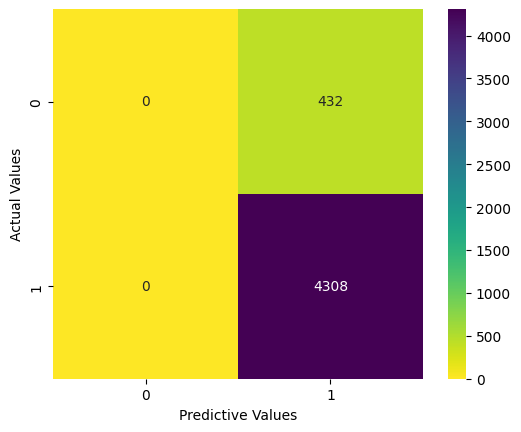

In [46]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
      Precision (test): {prec_test:.3f}
      Recall (test): {rec_test:.3f}
''')

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel("Predictive Values")
ax.set_ylabel("Actual Values")